### Program Overview

Put things about the program here
__________________________________________________________________________

### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the server. Plotting tools are also imported here.

In [1]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

import sys
import collections
import math
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import ipywidgets as widgets

### Acquiring annotation set

We query the server for the dataset, which is the 1k-genomes dataset. The dataset has a unique ID that can be used to acquire each variant set within the dataset. 

To access the different kinds of annotations, we access the annotation set using the unique variant set ID.

In [2]:
dataset = c.search_datasets().next()

for variantSet in c.search_variant_sets(dataset.id):
    if variantSet.name == "functional-annotation":
        annotation = variantSet

annotationSet = c.search_variant_annotation_sets(variant_set_id=annotation.id).next()

### Running Search

runSearch is called below using ipywidgets. Global variables are initialized for other functions to use and the start and end points are set based on how many buckets the user wants. The function then searches for the transcript effects, given the transcript effect the user is looking for.

The function consists of a loop that is used to separate the search into the amount of buckets, or windowCount, the user wants to find. This makes it easier to visualize large portions of data in a succinct way

The results are sent to countingStatistics for further processing.

In [15]:
def runSearch(startPos, endPos, chromosome, searchTerms, buckets):
    
    global formatSearch
    formatSearch = []
    
    for i in range(0,len(searchTerms)):
        formatSearch.append({"id":searchTerms[i]})
           
    global windowCount
    windowCount = int(buckets)
    
    global initStart
    global initEnd
    initStart = startPos
    initEnd = endPos
    
    global startPoint
    global endPoint
    startPoint = int(startPos)
    endPoint = (int(startPos)+(int(endPos)-int(startPos))/int(buckets))
    
    global yList
    global xTickList
    yList=[]
    xTickList=[]
    
    global allGraphData
    allGraphData = []
    
    global count
    count=0
    
    # formatSearch loop breaks up the search by different search terms
    for soTerms in formatSearch:
        # windowCount/bucket loop breaks up the search into multiple smaller searches from region to region
        for i in range(0,windowCount):
            #print(soTerms)
            searchedVarAnns=c.search_variant_annotations(variant_annotation_set_id=annotationSet.id, start=startPoint, end=endPoint, reference_name=chromosome, effects=[soTerms])

            idList = []
            startEndList = []

            for annotation in searchedVarAnns:
                idList.append(annotation.variant_id)

            countingStats(idList=idList, windowValue=windowCount, yValList=yList, startPos=startPoint, endPos=endPoint)

            startPoint+=(int(endPos)-int(startPos))/int(buckets)
            endPoint+=(int(endPos)-int(startPos))/int(buckets)
            
            del idList[:]

### Counting Statistics

countingStats arranges the data in a way that will work nicely with matplotlib. The values are then passed onto the plotting function.

In [16]:
def countingStats(idList, windowValue, yValList,startPos, endPos):

    if len(yList)==0:
        yList.append([])
    
    yList[count].append(len(idList))
    
    if len(yList[count])==windowValue:
        global startPoint
        startPoint = int(initStart)-(int(initEnd)-int(initStart))/windowCount
    
        global endPoint
        endPoint = (int(initStart)+(int(initEnd)-int(initStart))/windowCount)-(int(initEnd)-int(initStart))/windowCount
        
        global count
        count+=1
    
        if count!=len(formatSearch):
            yList.append([])
    
    if len(yList)==len(formatSearch) and len(yList[count-1])==windowValue and count==len(formatSearch):
        plotWindowHistogram(xTickList, yList, windowValue, startPos, endPos)

<ipython-input-16-4912ead13a62>:15: SyntaxWarning: name 'count' is used prior to global declaration
  global count


### Plotting

All the statistics are gathered and then graphed. The function also sets the appropriate title, x-axis labels, and different bar colors depending on the search results.

In [17]:
def plotWindowHistogram(xAxisTicks, yAxisValues, windowVals, startPos, endPos):

    fig, ax = plt.subplots()
    
    endValues = np.empty([1,2], dtype=np.int32)

    endValues[0][0] = startPos
    endValues[0][1] = endPos
    
    # Set labels here#####
    #ax.set_xticklabels(endValues, rotation=90)
    
    colors = [str]*20
    colors[0] = '#8B0000'
    colors[1] = '#FF8C00'
    colors[2] = '#8B008B'
    colors[3] = '#556B2F'
    colors[4] = '#006400'
    colors[5] = '#9932CC'
    colors[6] = '#BDB76B'
        
    #h = plt.bar(xrange(len(xAxisTicks)), yAxisValues, label=xAxisTicks)
    #xticks_pos = [0.50*patch.get_width() + patch.get_xy()[0] for patch in h]
    #plt.xticks(xticks_pos, xAxisTicks,  ha='right', rotation=45) 
    
    #print(yAxisValues)
  

    # title and graph size formatting
    titleEffects=[]
    for key, value in searchOntologyDict.iteritems():
        for i in range(len(formatSearch)):
            if searchOntologyDict[key]==formatSearch[i]['id']:
                titleEffects.append(key)


    index=0
    for j in range(0,len(yAxisValues[index])):
        for i in range(0,count):
            if j==0:
                plt.bar(index, yAxisValues[i][j], width=1, color=colors[i], label=titleEffects[i])
            else:
                plt.bar(index, yAxisValues[i][j], width=1, color=colors[i])
            index+=1
            

    title=""
    if len(titleEffects)==1:
        ax.set_title(titleEffects[0]+"s"+" from "+str(initStart)+" to "+str(initEnd))
    else:
        if len(formatSearch)==2:
            title+=titleEffects[0]+"s"+" and "+titleEffects[1]+"s"+" "
        else:
            for i in range(0,len(titleEffects)):
                if i!=(len(titleEffects)-1):
                    title+=titleEffects[i]+"s"+", "
                else:
                    title+="and "+titleEffects[i]+"s"+" "
        ax.set_title(title+"from "+str(initStart)+" to "+str(initEnd))

        
    plt.legend(loc='upper right')
        
    #ax.set_ylim([0,int(math.ceil(max(yAxisValues)/5.0))*5])
    

    
    # Set labels here#####
    #ax.set_xticklabels(xTickList)
    plt.rcParams["figure.figsize"] = [15,15]
        
    plt.show()

### Interact Widgets

A dictionary of transcript effects and their search ontology ID's is made so that the user doesn't have to remember the ID's. runSearch is then called and the interact function gives" runSearch all of the necessary parameters based on what the user has chosen.

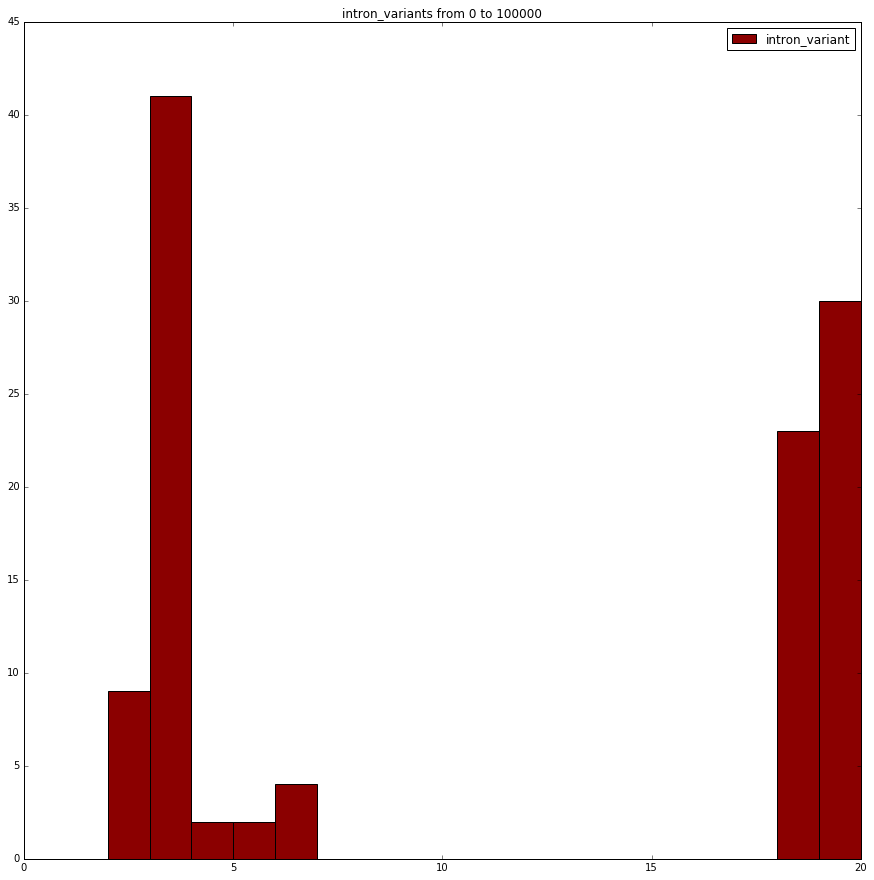

In [20]:
shortDict = {'intron_variant' : 'SO:0001627', 'feature_truncation' : 'SO:0001906' , 'non_coding_transcript_exon_variant' : 'SO:0001792' , 'non_coding_transcript_variant' : 'SO:0001619', 'transcript_ablation' : 'SO:0001893'}
chromList = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18')

global searchOntologyDict
searchOntologyDict = {
    'stop_retained_variant' :              'SO:0001567',
    'regulatory_region_variant' :          'SO:0001566',
    'splice_acceptor_variant' :            'SO:0001574',
    'splice_donor_variant' :               'SO:0001575',
    'missense_variant' :                   'SO:0001583',
    'stop_gained' :                        'SO:0001587',
    'stop_lost' :                          'SO:0001578',
    'frameshift_variant' :                 'SO:0001589',
    'coding_sequence_variant' :            'SO:0001580',
    'non_coding_transcript_variant' :      'SO:0001619',
    'mature_miRNA_variant' :               'SO:0001620',
    'NMD_transcript_variant' :             'SO:0001621',
    '5_prime_UTR_variant' :                'SO:0001623',
    '3_prime_UTR_variant' :                'SO:0001624',
    'incomplete_terminal_codon_variant' :  'SO:0001626',
    'intron_variant' :                     'SO:0001627',
    'intergenic_variant' :                 'SO:0001628',
    'splice_region_variant' :              'SO:0001630',
    'upstream_gene_variant' :              'SO:0001631',
    'downstream_gene_variant' :            'SO:0001632',
    'TF_binding_site_variant' :            'SO:0001782',
    'non_coding_transcript_exon_variant' : 'SO:0001792',
    'protein_altering_variant' :           'SO:0001818',
    'synonymous_variant' :                 'SO:0001819',
    'inframe_insertion' :                  'SO:0001821',
    'inframe_deletion' :                   'SO:0001822',
    'transcript_amplification' :           'SO:0001889',
    'regulatory_region_amplification' :    'SO:0001891',
    'TFBS_ablation' :                      'SO:0001892',
    'TFBS_amplification' :                 'SO:0001892',
    'regulatory_region_ablation' :         'SO:0001894',
    'feature_truncation' :                 'SO:0001906',
    'feature_elongation' :                 'SO:0001907',
    'start_lost' :                         'SO:0002012',
}

multiSelect = widgets.SelectMultiple(
    description="Transcript Effects",
    options=searchOntologyDict
)

interact(runSearch,
         startPos="0",
         endPos="100000",
         chromosome=chromList,
         searchTerms=multiSelect,
         buckets="20",
         __manual="True"
         )